In [3]:
# Import libs

# Set CPU for nn work
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Model
from keras.layers import Input, Embedding, GRU, LSTM, Dense, BatchNormalization, Dropout, concatenate
from keras.callbacks import EarlyStopping

In [ ]:
# Get stopwords & tokenizer data

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Grab data

df = pd.read_csv(open('enronSpamSubset.csv', 'rb'))
df.head()

,Unnamed: 0.1,Unnamed: 0,Body,Label
0,2469,2469,Subject: stock promo mover : cwtd\n * * * urge...,1
1,5063,5063,Subject: are you listed in major search engine...,1
2,12564,12564,"Subject: important information thu , 30 jun 20...",1
3,2796,2796,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,1468,1468,"Subject: "" bidstogo "" is places to go , things...",1


In [ ]:
# Get rid of useless colums

df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
df.head()

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [ ]:
# Have no Nans

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    10000 non-null  object
 1   Label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
df.duplicated().sum()

313

In [ ]:
# Drop 313 duplicates

df = df.drop_duplicates(keep = 'first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9687 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    9687 non-null   object
 1   Label   9687 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 227.0+ KB


In [ ]:
# NLP preprocess
# set lower case

df['Body'] = df['Body'].str.lower()
df.head()

<ipython-input-12-bbb8833fa372>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Body'] = df['Body'].str.lower()


,Body,Label
0,subject: stock promo mover : cwtd\n * * * urge...,1
1,subject: are you listed in major search engine...,1
2,"subject: important information thu , 30 jun 20...",1
3,subject: = ? utf - 8 ? q ? bask your life with...,1
4,"subject: "" bidstogo "" is places to go , things...",1


In [ ]:
# Track 2'nd row

df['Body'].loc[1]

'subject: are you listed in major search engines ?\n submitting your website in search engines may increase\n your online sales dramatically .\n lf you invested time and money into your website , you\n simply must submit your website\n oniine otherwise it wili be invisible virtuaiiy , which means efforts spent in vain .\n lf you want\n peopie to know about your website and boost your revenues , the only way to do\n that is to\n make your site visible in places\n where people search for information , i . e .\n submit your\n website in multipie search engines .\n submit your website online\n and watch visitors stream to your e - business .\n best reqards ,\n brittnyatkins _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ not interested . . . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [ ]:
# Grab subject from texts and make independant colum

df['Subject'] = df['Body'].str.extract(r'subject:\s*(.*)')
df['Body'] = df['Body'].str.replace(r'subject:\s*(.*)', '')
df.head()

<ipython-input-14-4bcb731453b3>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Body'] = df['Body'].str.replace(r'subject:\s*(.*)', '')


,Body,Label,Subject
0,\n * * * urgent investor trading alert * * *\n...,1,stock promo mover : cwtd
1,\n submitting your website in search engines m...,1,are you listed in major search engines ?
2,"\n subject : important information thu , 30 ju...",1,"important information thu , 30 jun 2005 ."
3,\n = ? utf - 8 ? q ? individual incremen ? =\n...,1,= ? utf - 8 ? q ? bask your life with ? =
4,"\n hello ,\n privacy policy : to\n permanently...",1,""" bidstogo "" is places to go , things to do"


In [ ]:
# keep tracking 2'nd row

df['Body'].loc[1]

'\n submitting your website in search engines may increase\n your online sales dramatically .\n lf you invested time and money into your website , you\n simply must submit your website\n oniine otherwise it wili be invisible virtuaiiy , which means efforts spent in vain .\n lf you want\n peopie to know about your website and boost your revenues , the only way to do\n that is to\n make your site visible in places\n where people search for information , i . e .\n submit your\n website in multipie search engines .\n submit your website online\n and watch visitors stream to your e - business .\n best reqards ,\n brittnyatkins _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ not interested . . . _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _'

In [ ]:
# Get some featurs like num characters, num words & num sentence
# This can be helpfull

df['body_num_characters'] = df['Body'].apply(len)
df['body_num_words'] = df['Body'].apply(lambda x: len(nltk.word_tokenize(x)))
df['body_num_sentence'] = df['Body'].apply(lambda x: len(nltk.sent_tokenize(x)))

df

,Body,Label,Subject,body_num_characters,body_num_words,body_num_sentence
0,\n * * * urgent investor trading alert * * *\n...,1,stock promo mover : cwtd,6177,1092,43
1,\n submitting your website in search engines m...,1,are you listed in major search engines ?,849,221,10
2,"\n subject : important information thu , 30 ju...",1,"important information thu , 30 jun 2005 .",729,140,12
3,\n = ? utf - 8 ? q ? individual incremen ? =\n...,1,= ? utf - 8 ? q ? bask your life with ? =,493,104,15
4,"\n hello ,\n privacy policy : to\n permanently...",1,""" bidstogo "" is places to go , things to do",1231,237,19
...,...,...,...,...,...,...
9995,"\n louise ,\n do you have half an hour or so f...",0,monday 22 nd oct,129,33,4
9996,\n stephanie -\n i believe i ' ve found these ...,0,missing bloomberg deals,7832,1801,64
9997,\n we will need to establish a deadline . will...,0,eops salary survey questionnaire,1302,324,7
9998,"\n hi louise ,\n i have a comparison for the f...",0,q 3 comparison,256,63,6


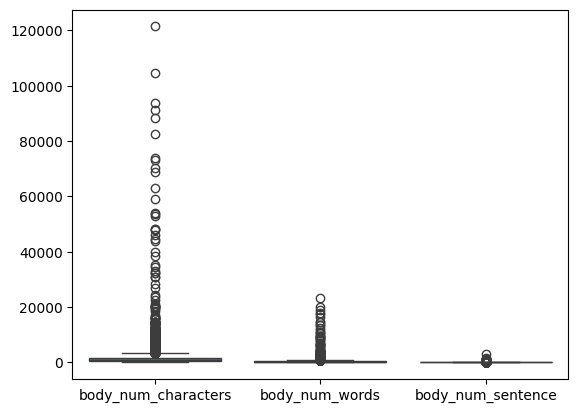

In [ ]:
# We have a lot of outlines

sns.boxplot(df[['body_num_characters', 'body_num_words', 'body_num_sentence']])
plt.show()

In [ ]:
df.describe()

,Label,body_num_characters,body_num_words,body_num_sentence
count,9687.000000,9687.000000,9687.000000,9687.000000
mean,0.491380,1489.491071,303.197791,18.529163
std,0.499951,3923.007083,776.117733,57.725036
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,314.000000,64.000000,5.000000
50%,0.000000,673.000000,144.000000,9.000000
75%,1.000000,1532.500000,319.000000,18.000000
max,1.000000,121479.000000,23341.000000,3093.000000


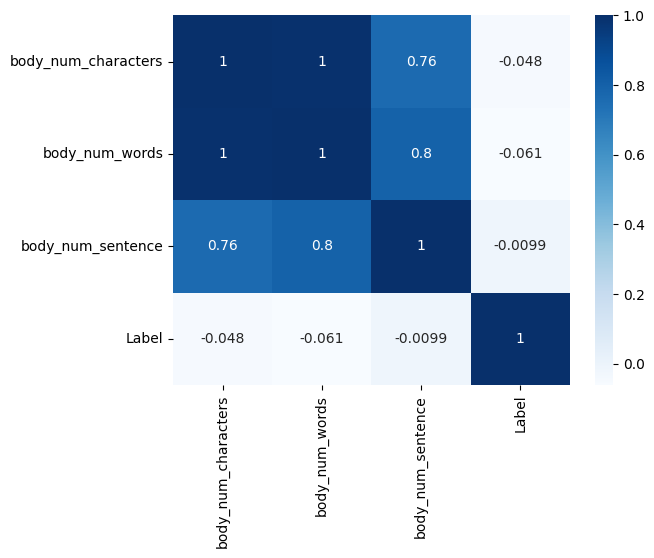

In [ ]:
# Copy data frame, and show corralation matrix
# NExt we will drop outlines and compare correlation

df_copy = df.copy()

sns.heatmap(df_copy[['body_num_characters', 'body_num_words', 'body_num_sentence', 'Label']].corr(), cmap = 'Blues', annot = True)
plt.show()

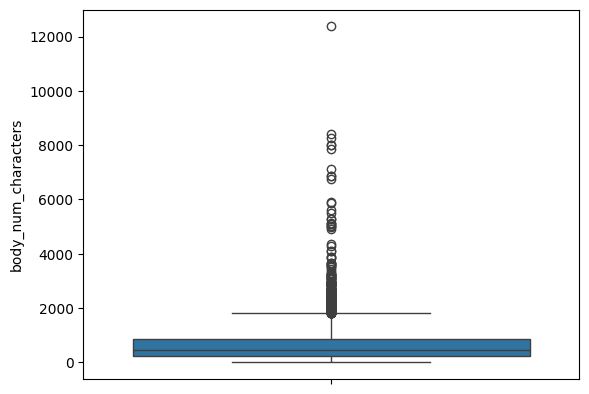

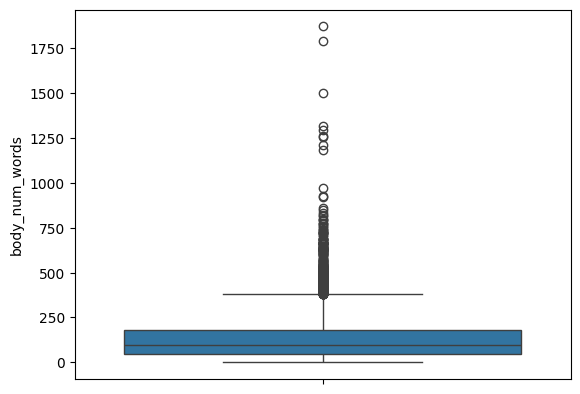

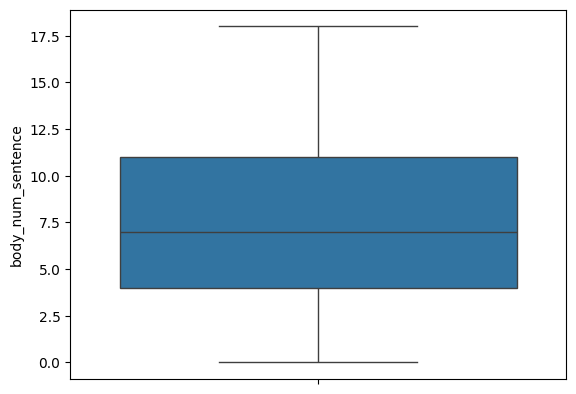

In [ ]:
# Drop outlins

df = df[df['body_num_sentence'] < 19]

for i in ['body_num_characters', 'body_num_words', 'body_num_sentence']:
    sns.boxplot(df[i])
    plt.show()

In [ ]:
df.describe()

,Label,body_num_characters,body_num_words,body_num_sentence
count,7316.000000,7316.000000,7316.000000,7316.000000
mean,0.485785,649.173455,134.095544,7.543056
std,0.499832,646.967166,127.240371,4.673531
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,243.000000,49.000000,4.000000
50%,0.000000,471.500000,99.000000,7.000000
75%,1.000000,866.250000,181.000000,11.000000
max,1.000000,12375.000000,1871.000000,18.000000


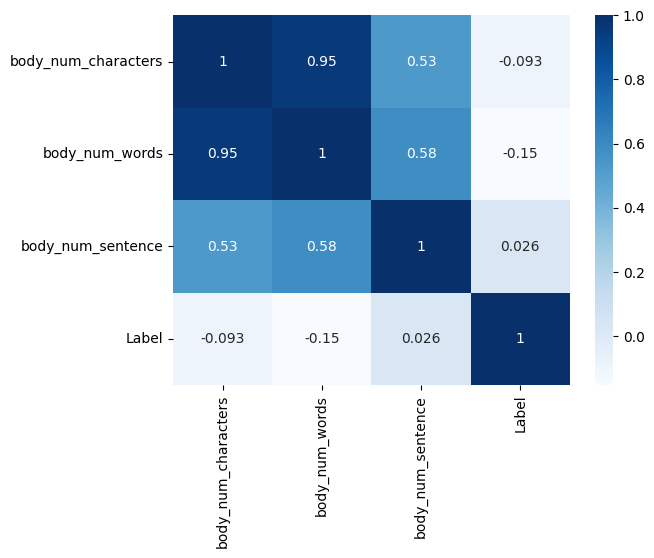

In [ ]:
# Show up to droped correlation

sns.heatmap(df[['body_num_characters', 'body_num_words', 'body_num_sentence', 'Label']].corr(), cmap = 'Blues', annot = True)
plt.show()

In [ ]:
# Correlation became better, so we do not need df_copy anymore

df_copy = None

In [ ]:
# Get rid of punctuation & non  the latin alphabet

for i in ['Body', 'Subject']:
    df[i] = df[i].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    df[i] = df[i].apply(lambda x: ''.join([char for char in x if ord(char) < 128]))
    df[i] = df[i].str.replace('\n', '')


df.head()

<ipython-input-24-01ac7c3c708d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
<ipython-input-24-01ac7c3c708d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = df[i].apply(lambda x: ''.join([char for char in x if ord(char) < 128]))
<ipython-input-24-01ac7c3c708d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,Body,Label,Subject,body_num_characters,body_num_words,body_num_sentence
1,submitting your website in search engines may...,1,are you listed in major search engines,849,221,10
2,subject important information thu 30 jun 20...,1,important information thu 30 jun 2005,729,140,12
3,utf 8 q individual incremen utf 8 ...,1,utf 8 q bask your life with,493,104,15
5,chheap softtwares for you all are original o...,1,dont pay more than 100 for ur softwares miseries,1172,218,11
6,micros 0 ft for pennies check em out carney ...,1,paliourg,166,24,1


In [ ]:
df['Body'].loc[1]

' submitting your website in search engines may increase your online sales dramatically  lf you invested time and money into your website  you simply must submit your website oniine otherwise it wili be invisible virtuaiiy  which means efforts spent in vain  lf you want peopie to know about your website and boost your revenues  the only way to do that is to make your site visible in places where people search for information  i  e  submit your website in multipie search engines  submit your website online and watch visitors stream to your e  business  best reqards  brittnyatkins                                                       not interested                                                         '

In [ ]:
# Define function to process samming & stop words delition

ps = PorterStemmer()

def transform_text(text):
    # Tokenization using NLTK
    text = nltk.word_tokenize(text)

    y = []

    # Loop through the tokens and remove stopwords and punctuation
    for i in text:
        if i not in stopwords.words('english'):
            y.append(i)

    # Stemming using Porter Stemmer
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [ ]:
# Apply stop words delition & stamming

df['Body'] = df['Body'].apply(transform_text)
df['Subject'] = df['Subject'].apply(transform_text)

df.head()

<ipython-input-27-c0f5c740a550>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Body'] = df['Body'].apply(transform_text)
<ipython-input-27-c0f5c740a550>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Subject'] = df['Subject'].apply(transform_text)


,Body,Label,Subject,body_num_characters,body_num_words,body_num_sentence
1,submit websit search engin may increas onlin s...,1,list major search engin,849,221,10
2,subject import inform thu 30 jun 2005 thank us...,1,import inform thu 30 jun 2005,729,140,12
3,utf 8 q individu incremen utf 8 q intern secre...,1,utf 8 q bask life,493,104,15
5,chheap softtwar origin oemmajor titl micro 0 f...,1,dont pay 100 ur softwar miseri,1172,218,11
6,micro 0 ft penni check em carney handwrit perp...,1,paliourg,166,24,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7316 entries, 1 to 9999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Body                 7316 non-null   object
 1   Label                7316 non-null   int64 
 2   Subject              7316 non-null   object
 3   body_num_characters  7316 non-null   int64 
 4   body_num_words       7316 non-null   int64 
 5   body_num_sentence    7316 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 658.1+ KB


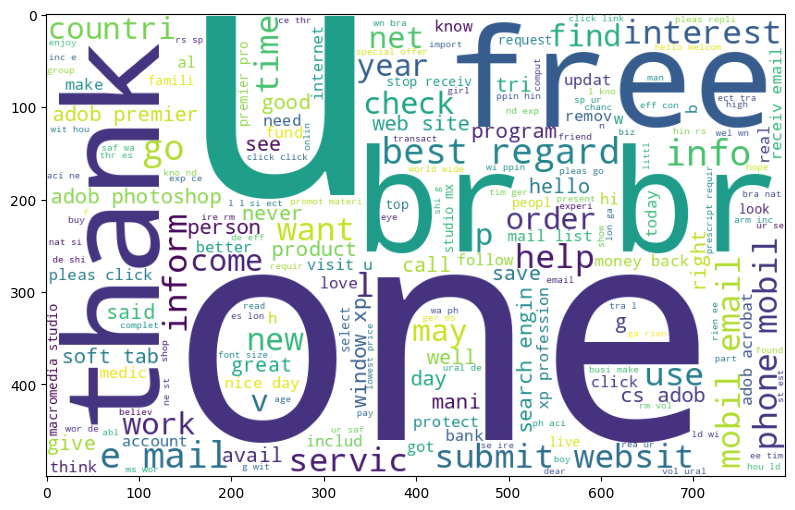

In [ ]:
# Show Cloud of words for smap messages

wc = WordCloud(width = 800, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['Label'] == 1]['Body'].str.cat(sep = " "))
plt.figure(figsize = (15, 6))
plt.imshow(spam_wc)
plt.grid(False)
plt.show()

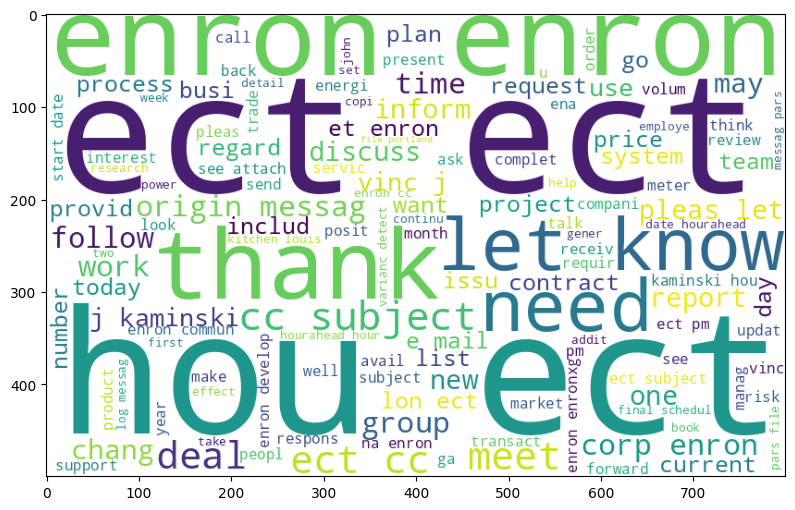

In [ ]:
# Show Cloud of words for non smap messages

wc = WordCloud(width = 800, height = 500, min_font_size = 10, background_color = 'white')
spam_wc = wc.generate(df[df['Label'] == 0]['Body'].str.cat(sep = " "))
plt.figure(figsize = (15, 6))
plt.imshow(spam_wc)
plt.grid(False)
plt.show()

In [ ]:
# Use LDA to get 16 topics from the body column

# So we drop soma data, we need to reset indexes
df = df.reset_index(drop = True)

# Get Bag of words and fit in on all body text
vectorizer = CountVectorizer(max_df = 0.95, min_df = 2)
X = vectorizer.fit_transform(df['Body'].values.astype('U'))

# Get X in format that gensim use to grab topicks
# Ans set ids to each words from corpus
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns = False)
idexies = Dictionary.from_corpus(corpus, id2word = dict((id, word) for word, id in vectorizer.vocabulary_.items()))

# Grab some topicks
num_topics = 16
lda_model = LdaModel(corpus = corpus, id2word = idexies, num_topics = num_topics, passes = 15)
topics = lda_model[corpus]

# Create tmp df to store topicks
topics_df = pd.DataFrame(index = df.index, columns = [f'Topic_{i + 1}' for i in range(num_topics)], dtype = float)

for i, doc_topics in enumerate(topics):
    for topic, weight in doc_topics:
        topics_df.at[i, f'Topic_{topic + 1}'] = weight


# So if LDA cannot grab topic, it set NA, simple replace this with 0
topics_df = topics_df.fillna(0.0)

# And concatenate with originla df
df = pd.concat([df, topics_df], axis = 1)
df.head()

,Body,Label,Subject,body_num_characters,body_num_words,body_num_sentence,Topic_1,Topic_2,Topic_3,Topic_4,...,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16
0,submit websit search engin may increas onlin s...,1,list major search engin,849,221,10,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.983835,0.0,0.000000
1,subject import inform thu 30 jun 2005 thank us...,1,import inform thu 30 jun 2005,729,140,12,0.000000,0.000000,0.236651,0.307752,...,0.0,0.0,0.0,0.0,0.0,0.07361,0.000000,0.297240,0.0,0.000000
2,utf 8 q individu incremen utf 8 q intern secre...,1,utf 8 q bask life,493,104,15,0.000000,0.000000,0.541848,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.223211,0.0,0.046439
3,chheap softtwar origin oemmajor titl micro 0 f...,1,dont pay 100 ur softwar miseri,1172,218,11,0.156094,0.113843,0.195737,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.085443,0.000000,0.0,0.035489
4,micro 0 ft penni check em carney handwrit perp...,1,paliourg,166,24,1,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000


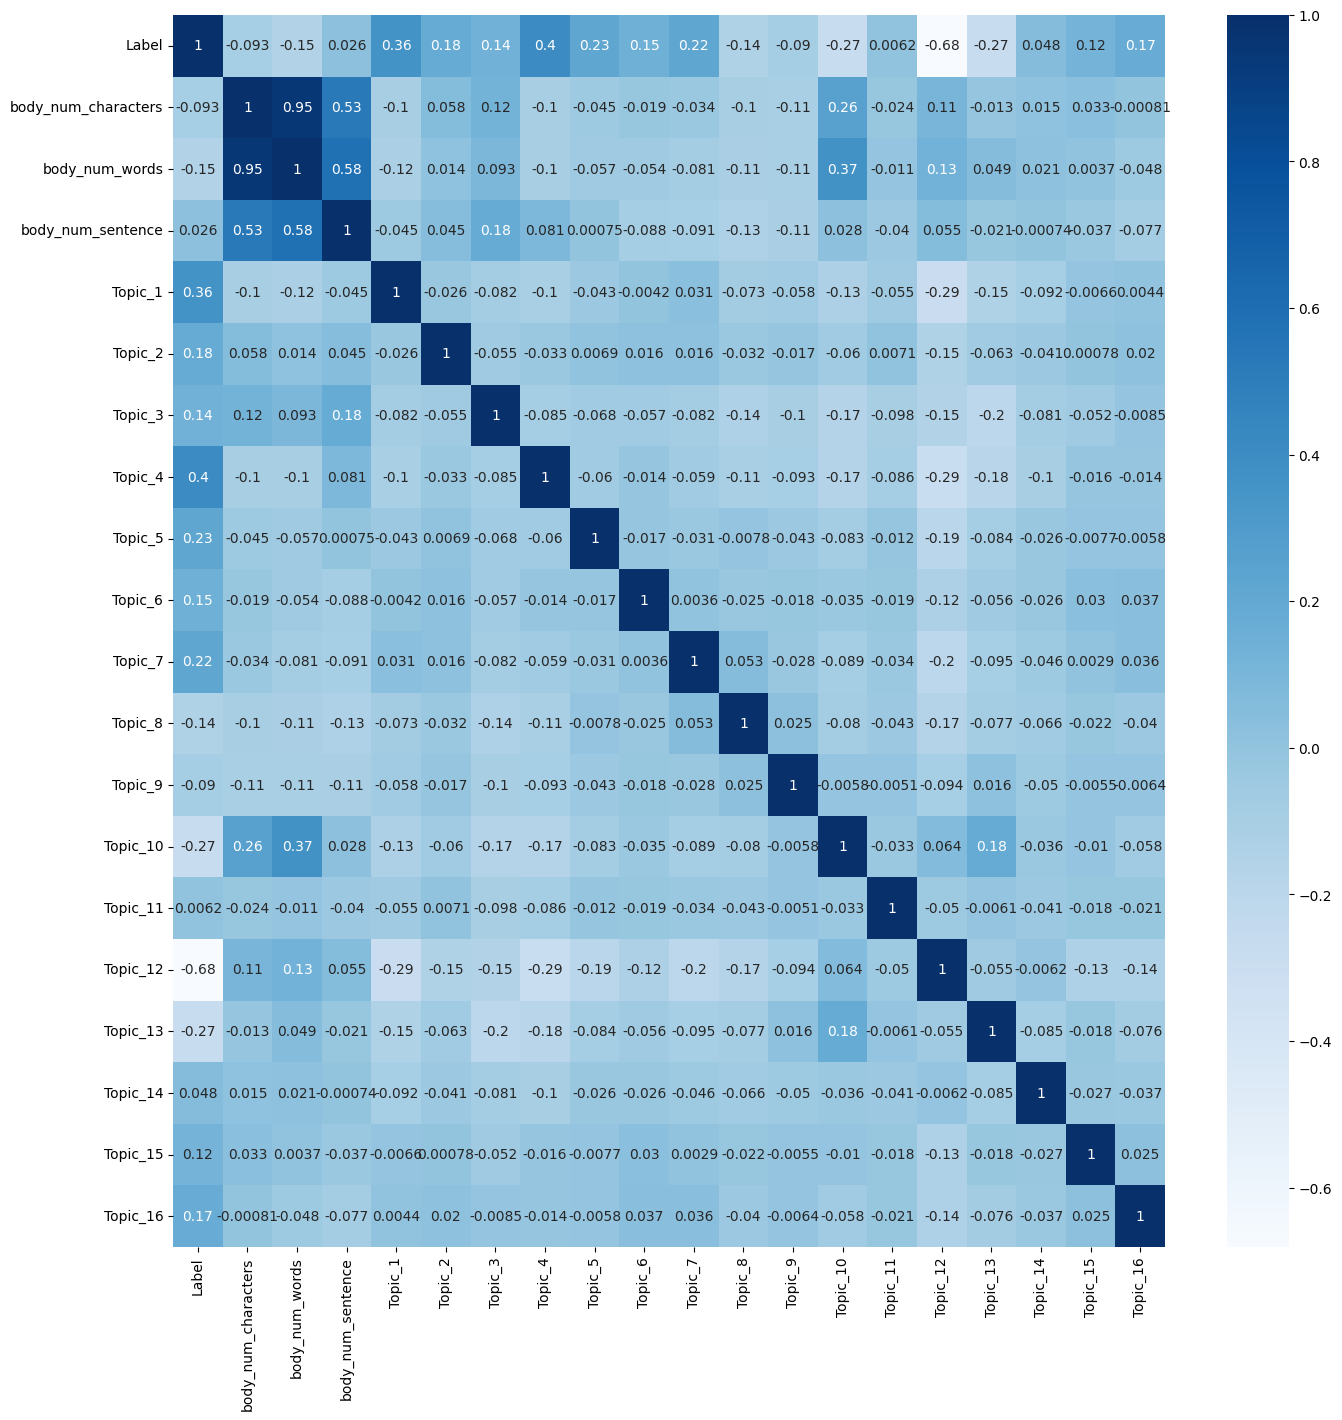

In [ ]:
# Show Pirson's correaltion

plt.figure(figsize = (16, 16))
sns.heatmap(df.drop(['Body', 'Subject'], axis = 1).corr(), cmap = 'Blues', annot = True)
plt.show()

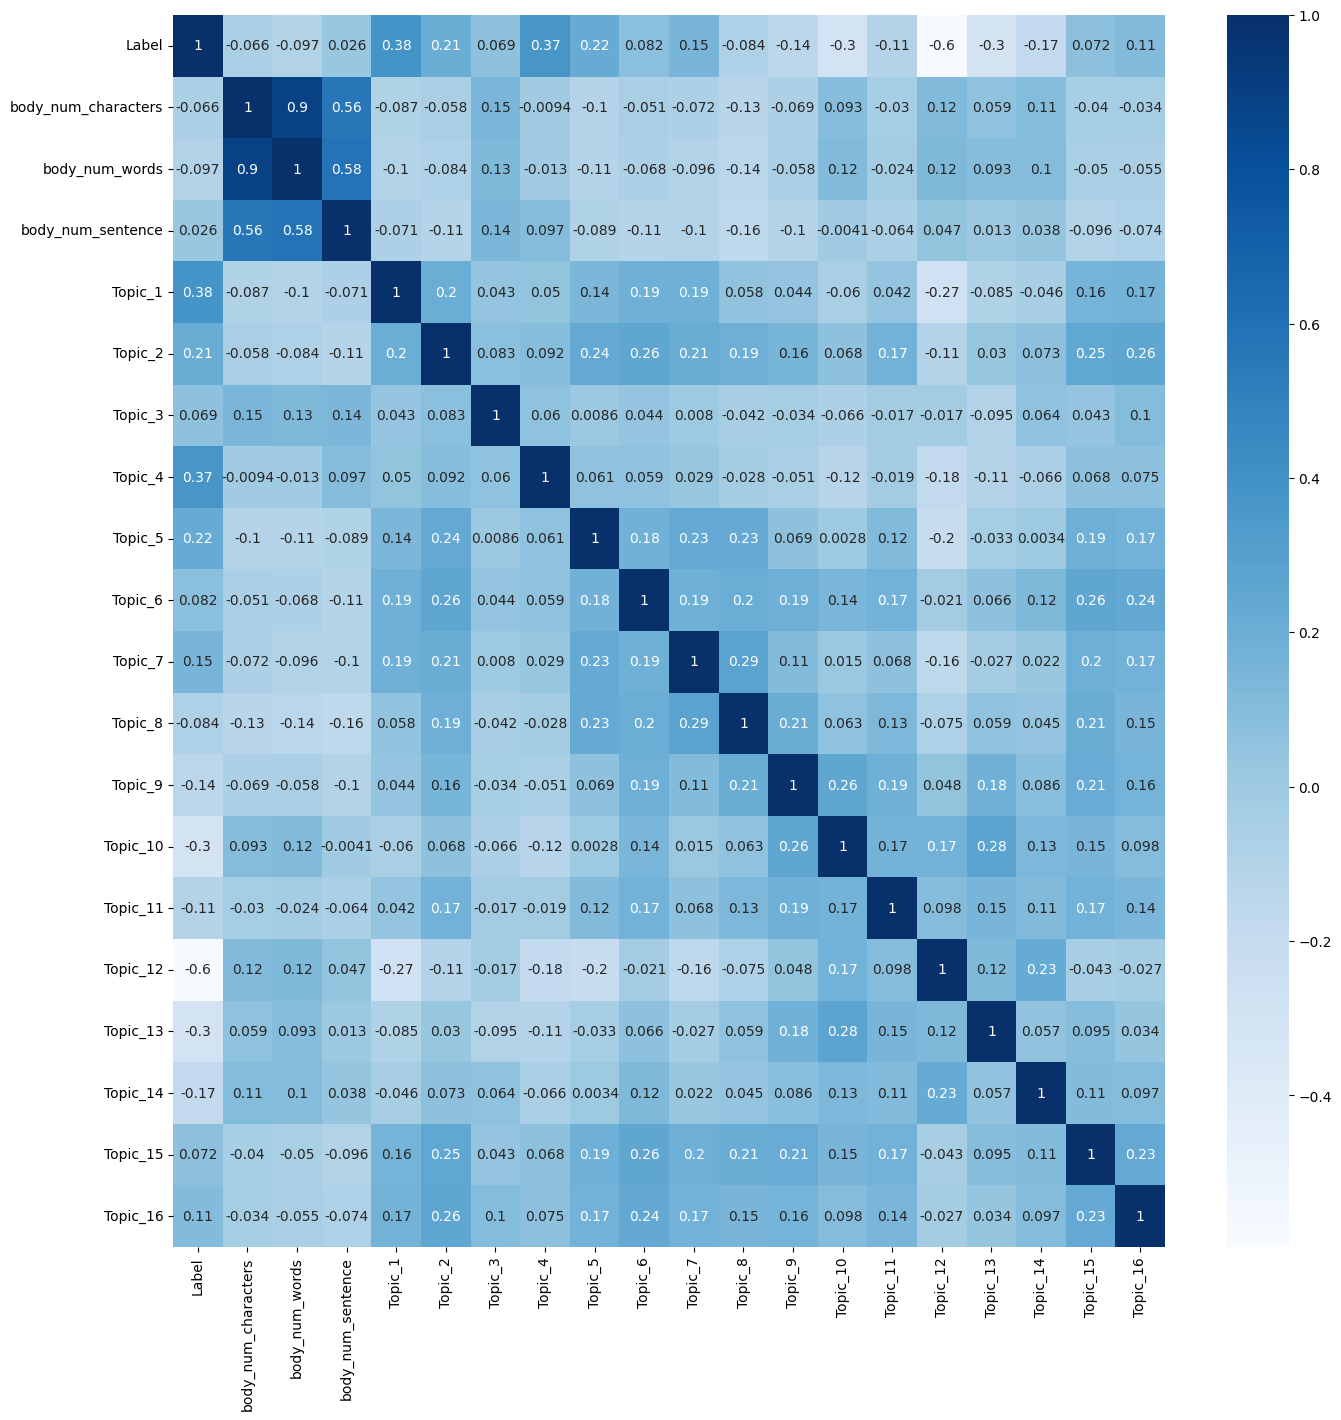

In [ ]:
# Show Kendall's correaltion

plt.figure(figsize = (16, 16))
sns.heatmap(df.drop(['Body', 'Subject'], axis = 1).corr(method = 'kendall'), 
            cmap = 'Blues', annot = True)
plt.show()

In [ ]:
# Encode subject using tf-idf & max vocabulary size in 100

# fit tf-idf vectorization on subject texts
tfidf_vectorizer_subject = TfidfVectorizer(max_features = 1000)
tfidf_matrix_subject = tfidf_vectorizer_subject.fit_transform(df['Subject'].values.astype('U'))
tfidf_df_subject = pd.DataFrame(data = tfidf_matrix_subject.toarray(), columns = tfidf_vectorizer_subject.get_feature_names_out())

# And concatenate with originla df
df = pd.concat([df, tfidf_df_subject], axis = 1)

df.shape

(7316, 1022)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7316 entries, 0 to 7315
Columns: 1022 entries, Body to zone
dtypes: float64(1016), int64(4), object(2)
memory usage: 57.0+ MB


In [ ]:
# Save Subject & Body for LSTM model, in logistic regression we do not need this

texts = df[['Subject', 'Body']].copy()

df = df.drop(['Subject', 'Body'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7316 entries, 0 to 7315
Columns: 1020 entries, Label to zone
dtypes: float64(1016), int64(4)
memory usage: 56.9 MB


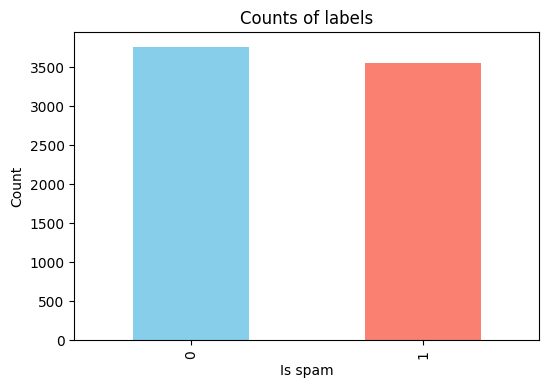

In [ ]:
# See if we have classes imbalance

plt.figure(figsize = (6, 4))
df['Label'].value_counts().plot(kind = 'bar', color = ['skyblue', 'salmon'])
plt.title('Counts of labels')
plt.xlabel('Is spam')
plt.ylabel('Count')
plt.show()

In [ ]:
# Preprocess data from model input

X = df.drop('Label', axis = 1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1212)

# We need to scale only this, cause other values get from tf-idf
to_scale = ['body_num_characters', 'body_num_words', 'body_num_sentence']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

# Use PCA, keep 25% of original number of columns
pca = PCA(n_components = df.shape[1] // 4)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# Fit logistic regression

model = LogisticRegression(penalty = 'l2')
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Show some metrics

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       742
           1       0.95      0.95      0.95       722

    accuracy                           0.95      1464
   macro avg       0.95      0.95      0.95      1464
weighted avg       0.95      0.95      0.95      1464



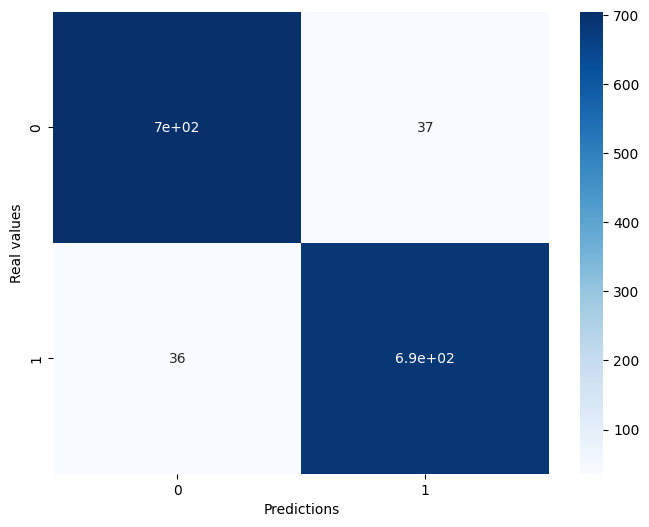

In [ ]:
# And confusin matrix

confusion = confusion_matrix(y_test, predicted)
plt.figure(figsize = (8, 6))
sns.heatmap(confusion, annot = True, cmap = 'Blues')    
plt.xlabel('Predictions')
plt.ylabel('Real values')
plt.show()

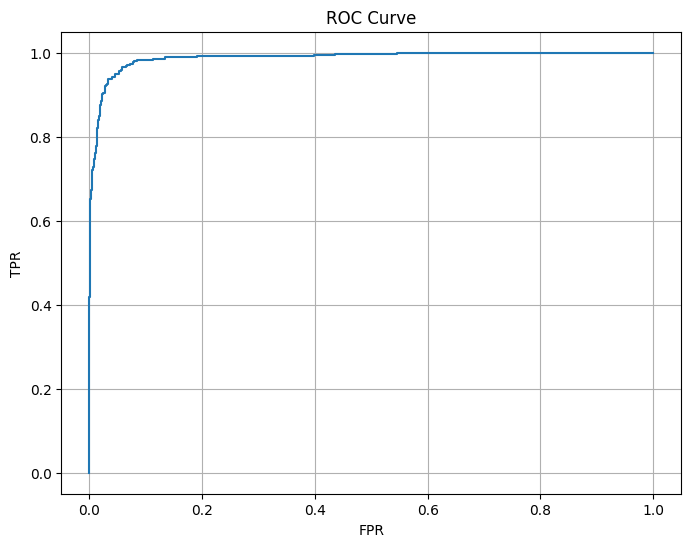

AUC-ROC Score: 0.9875383593044179


In [ ]:
# And roc-auc

predictions_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = 'ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

auc_roc = roc_auc_score(y_test, predictions_proba)
print('AUC-ROC Score:', auc_roc)

In [ ]:
# So we get closer to overfit resualt, try l1 regularization

model = LogisticRegression(solver = 'liblinear', penalty = 'l1')
model.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
# Show some metrics

predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       742
           1       0.95      0.95      0.95       722

    accuracy                           0.95      1464
   macro avg       0.95      0.95      0.95      1464
weighted avg       0.95      0.95      0.95      1464



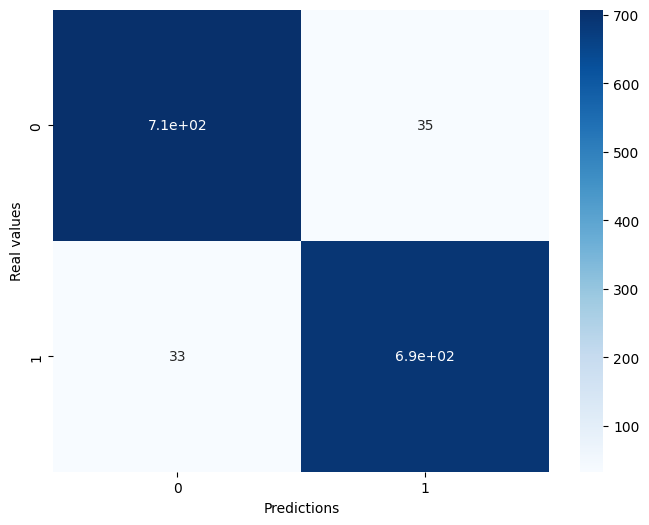

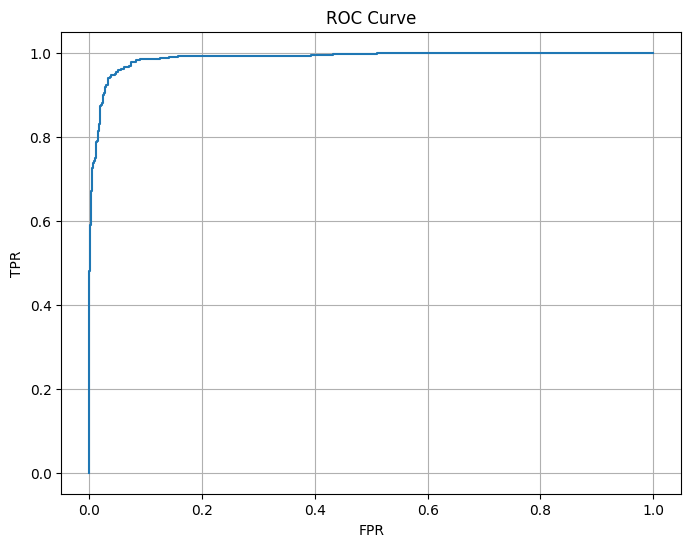

AUC-ROC Score: 0.9880050175090158


In [ ]:
# And plot metrics for l1

confusion = confusion_matrix(y_test, predicted)
plt.figure(figsize = (8, 6))
sns.heatmap(confusion, annot = True, cmap = 'Blues')
plt.xlabel('Predictions')
plt.ylabel('Real values')
plt.show()

predictions_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba)

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = 'ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

auc_roc = roc_auc_score(y_test, predictions_proba)
print('AUC-ROC Score:', auc_roc)

In [ ]:
# Try to fit LSTM model
# First of all keep 10000 most common words from Subject & Body
# next cut sentence down to 500 words to Body and 125 from Subject
# Set prefix padding

num_words = 10000

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(texts['Subject'] + ' ' + texts['Body'])
sequences_subject = tokenizer.texts_to_sequences(texts['Subject'])
sequences_body = tokenizer.texts_to_sequences(texts['Body'])

body_max_length = 500
padded_sequences_subject = pad_sequences(sequences_subject, maxlen = body_max_length // 4, padding = 'pre')
padded_sequences_body = pad_sequences(sequences_body, maxlen = body_max_length, padding = 'pre')

In [ ]:
# Smplit data into train & test

X_train_subject, X_test_subject, X_train_body, X_test_body, y_train, y_test = train_test_split(
    padded_sequences_subject, padded_sequences_body, to_categorical(df['Label']), train_size = 0.8, random_state = 1212)

In [ ]:
# So we have 2 inputs
# 1'st for Subject have GRU layers
# 2'nd for Body wth LSTM layers

# Both have BatchNormalization and Dropout to avoid overfitting

# Both layers conctaenate & affect output
# Output has 2 neurons for 0'th and 1'st classes

input_subject = Input(shape = (body_max_length // 4, ))
embedding_subject = Embedding(input_dim = num_words, output_dim = 2)(input_subject)
subject_1 = GRU(2, return_sequences = True, activation = 'leaky_relu')(embedding_subject)
subject_1 = BatchNormalization()(subject_1)
subject_1 = Dropout(0.5)(subject_1)
subject_2 = GRU(2, activation = 'leaky_relu')(subject_1)

input_body = Input(shape = (body_max_length, ))
embedding_body = Embedding(input_dim = num_words, output_dim = 4)(input_body)
body_1 = LSTM(4, return_sequences = True, activation = 'leaky_relu')(embedding_body)
body_1 = BatchNormalization()(body_1)
body_1 = Dropout(0.5)(body_1)
body_2 = LSTM(4, activation = 'leaky_relu')(body_1)

merged = concatenate([subject_2, body_2])

output = Dense(2, activation = 'softmax')(merged)

model = Model(inputs = [input_subject, input_body], outputs = output)

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model_42"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_91 (InputLayer)       [(None, 125)]                0         []                            
                                                                                                  
 input_92 (InputLayer)       [(None, 500)]                0         []                            
                                                                                                  
 embedding_89 (Embedding)    (None, 125, 2)               20000     ['input_91[0][0]']            
                                                                                                  
 embedding_90 (Embedding)    (None, 500, 4)               40000     ['input_92[0][0]']            
                                                                                           

In [ ]:
# Define early stopping to avoid overfitting

early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

In [ ]:
# And fit the model

history = model.fit(
    [X_train_subject, X_train_body],
    y_train,
    epochs = 50,
    batch_size = 256,
    validation_data = ([X_test_subject, X_test_body], y_test),
    callbacks = [early_stopping]
)

Epoch 1/50
24/24 [==============================] - 26s 748ms/step - loss: 0.6847 - accuracy: 0.6119 - val_loss: 0.6903 - val_accuracy: 0.5076
Epoch 2/50
24/24 [==============================] - 19s 784ms/step - loss: 0.6463 - accuracy: 0.7345 - val_loss: 0.6864 - val_accuracy: 0.5427
Epoch 3/50
24/24 [==============================] - 17s 704ms/step - loss: 0.5752 - accuracy: 0.7728 - val_loss: 0.6833 - val_accuracy: 0.8794
Epoch 4/50
24/24 [==============================] - 16s 689ms/step - loss: 0.4935 - accuracy: 0.8499 - val_loss: 0.6763 - val_accuracy: 0.5447
Epoch 5/50
24/24 [==============================] - 18s 744ms/step - loss: 0.4062 - accuracy: 0.8988 - val_loss: 0.6614 - val_accuracy: 0.4930
Epoch 6/50
24/24 [==============================] - 16s 684ms/step - loss: 12114283.0000 - accuracy: 0.9455 - val_loss: 0.6551 - val_accuracy: 0.4930
Epoch 7/50
24/24 [==============================] - 18s 740ms/step - loss: 0.2282 - accuracy: 0.9268 - val_loss: 0.6350 - val_accuracy:

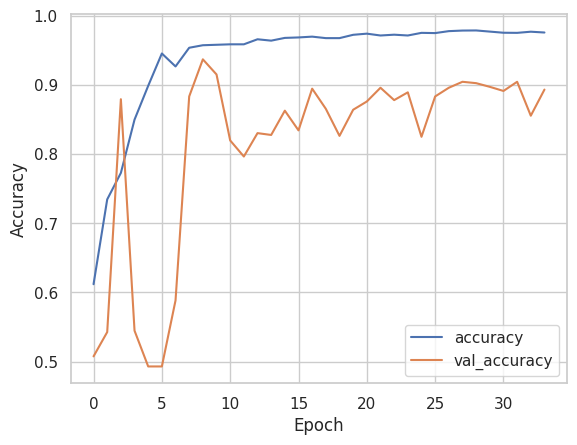

In [ ]:
# Show how it fit...
# accuracy & loss plots

plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.show()

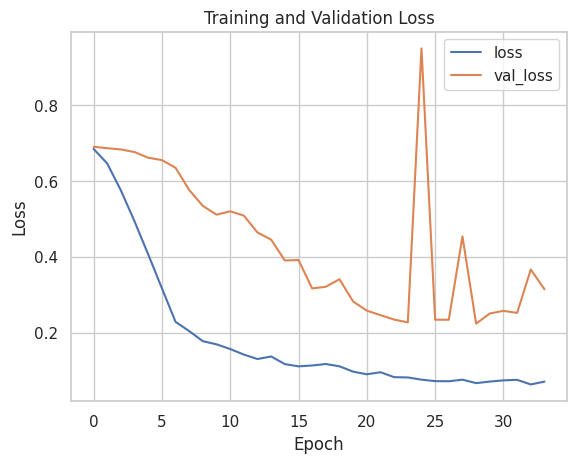

In [ ]:
# For some reasom we get 12114283.0000 on 6'th epoch
# In case not to ruined  plots, simple repcase it's values with mean of neubors 

loss = history.history['loss']
loss[5] = np.mean([loss[4], loss[6]])

plt.plot(loss, label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Some metrics

predicted = model.predict([X_test_subject, X_test_body])

predicted = np.argmax(predicted, axis = 1)
y_true = np.argmax(y_test, axis = 1)

print(classification_report(y_true, predicted))

48/48 [==============================] - 7s 131ms/step
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       743
           1       0.97      0.84      0.90       766

    accuracy                           0.90      1509
   macro avg       0.91      0.90      0.90      1509
weighted avg       0.91      0.90      0.90      1509



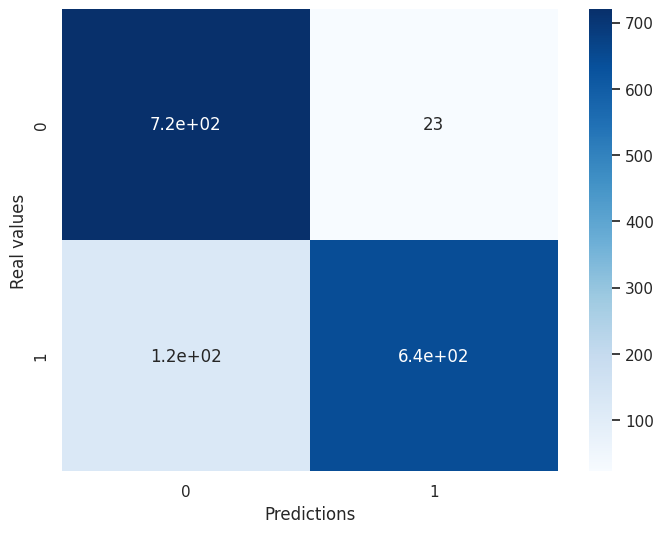

In [ ]:
# Showwhre model make mistacs

confusion = confusion_matrix(y_true, predicted)
plt.figure(figsize = (8, 6))
sns.heatmap(confusion, annot = True, cmap = 'Blues')
plt.xlabel('Predictions')
plt.ylabel('Real values')
plt.show()

48/48 [==============================] - 8s 163ms/step


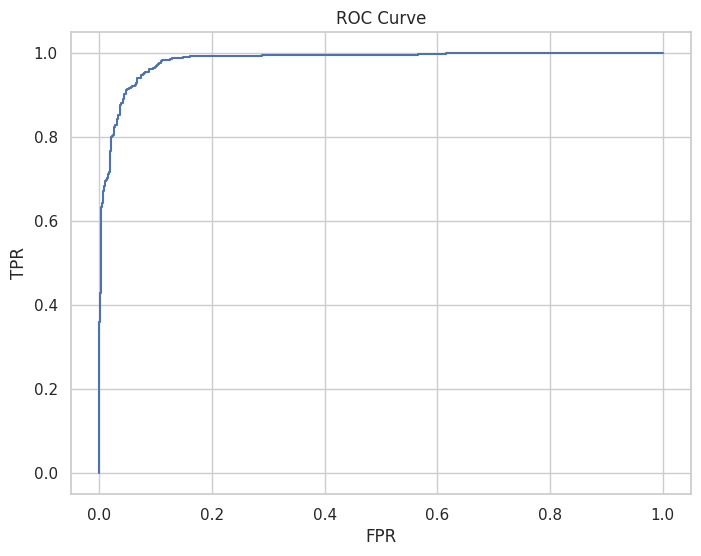

AUC-ROC Score: 0.9826786297875033


In [ ]:
# And roc-auc

predicted = model.predict([X_test_subject, X_test_body])

fpr, tpr, thresholds = roc_curve(y_true, predicted[:, 1])

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, label = 'ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

auc_roc = roc_auc_score(y_test, predicted)
print('AUC-ROC Score:', auc_roc)